## Node has tool and also want the response in json

In [1]:
from dotenv import load_dotenv, find_dotenv
load_dotenv()

True

In [2]:
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, ToolMessage, BaseMessage, AIMessage
from langgraph.graph import START, END, StateGraph, add_messages
from langchain_openai import ChatOpenAI
from typing import Literal, Annotated, Sequence, List, TypedDict
from langchain.pydantic_v1 import BaseModel, Field
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import RunnableConfig
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langchain.tools import tool

## Define Model

In [3]:
llm = ChatOpenAI(model = "gpt-4o-mini", temperature= 0)

## Define State

In [4]:
class State(TypedDict):
    messages : Annotated[Sequence[BaseMessage], add_messages]

## Define Tools

In [5]:
tavily_tool = TavilySearchResults(max_results=2)

class Response(BaseModel):
    location : str = Field("location")
    temperature : float = Field("temperature in the location")
    unit : Literal["celsius", "fahrenheit"] = Field(description= "unit of temperature. C will be used for celsius abd F will be used for fahrenheit")

@tool
def agent_response(Response):
    "Format the response"
    return Response

## Define Chain

In [6]:
prompt = ChatPromptTemplate.from_messages([
    ('system', 'You are helpful assistant. Provide the current location, temperature and unit in the required format'),
    MessagesPlaceholder(variable_name='messages')
    
])

chain = prompt | llm.bind_tools(tools=[agent_response, tavily_tool])

## Define Nodes

In [7]:
def agent_node(state : State):
    res = chain.invoke(state)
    return {"messages": res}

tool_node = ToolNode(tools= [tavily_tool, agent_response])

## Const

In [8]:
AGENT = "agent"
TOOL_NODE = "tool_node"

## Create Graph

In [9]:
def should_continue(state):
    count_tool_calls = sum(isinstance(message, ToolMessage) for message in state['messages'])
    print(f"count tool called : {count_tool_calls}")
    
    if count_tool_calls>=5:
        return "__end__"
    
    last_message = state['messages'][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls[0]['name'] == 'agent_response':
        return "__end__"

    return "continue"

In [10]:
workflow = StateGraph(State)
workflow.add_node(AGENT, agent_node)
workflow.add_node(TOOL_NODE, tool_node)
workflow.add_conditional_edges(AGENT, should_continue,{
    "continue": TOOL_NODE,
    "__end__": END
})
workflow.add_edge(TOOL_NODE, AGENT)
workflow.set_entry_point(AGENT)
graph = workflow.compile()

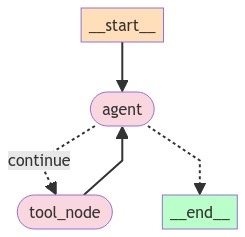

In [11]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
state = {
    "messages": [HumanMessage("What is the current temperature of Noida?")]
}

config = RunnableConfig(recursion_limit = 10)

In [13]:
result = graph.invoke(state, config= config)
result

count tool called : 0
count tool called : 1
count tool called : 2


{'messages': [HumanMessage(content='What is the current temperature of Noida?', id='bc248e86-026b-487e-9091-4a0ce6e1ad34'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4Xq4VJVHgdNeqZkzlfqicsFA', 'function': {'arguments': '{"query":"current temperature in Noida"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 124, 'total_tokens': 146}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_8b761cb050', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7e52558e-3218-4344-81ce-ec1f7ce818f9-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current temperature in Noida'}, 'id': 'call_4Xq4VJVHgdNeqZkzlfqicsFA'}]),
  ToolMessage(content='[{"url": "https://www.accuweather.com/en/in/noida/3146227/weather-forecast/3146227", "content": "Get the current weather forecast for Noida, Uttar Pradesh, India and access temperature, wind, humidity, UV ind

In [14]:
response = result['messages'][-1].tool_calls[0]['args']['Response']
response

{'location': 'Noida, Uttar Pradesh, India', 'temperature': 34.3, 'unit': 'C'}